### AE pytorch

In [1]:
from google.colab import drive
drive.mount('/content/drive')
data_path = 'drive/My Drive/Colab Notebooks/These/10_autoencoder_mp/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import MNIST
from torchsummary import summary

from tqdm import tqdm, tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def plot_gallery(images, h, w, n_row=3, n_col=3):
  """Helper function to plot a gallery of images"""
  plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
  plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
  for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i+1)
    temp = torch.transpose(images[i],0,2)
    temp = torch.transpose(temp,0,1)
    try:
      plt.imshow(temp, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
      plt.xticks(())
      plt.yticks(())
    except:
      pass

In [0]:
# define constants (hard code)
batch_size = 16
TRAIN_SIZE = 50000
VAL_SIZE = 10000
epochs = 50

In [5]:
# define transforms
img_transform = transforms.Compose([
                                    transforms.ToTensor(),
                                  #transforms.Normalize(0.5, 0.5)                                    
])

# load mnist dataset
dataset = MNIST('./data', transform=img_transform, download=True)

# define subset raandom samplers
np.random.seed(0)
indices = np.arange(len(dataset))
np.random.shuffle(indices)

TrainSampler = SubsetRandomSampler(indices[:TRAIN_SIZE])
ValSampler = SubsetRandomSampler(indices[TRAIN_SIZE:])

TrainLoader = DataLoader(dataset, batch_size=batch_size, sampler=TrainSampler)
ValLoader = DataLoader(dataset, batch_size=batch_size, sampler=ValSampler)

#class MnistDataset(Dataset):
#  def __init__(self):
#  def __getitem__(self, idx):

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [6]:
# check dataset
print(len(dataset), dataset[0][0].shape, dataset[0][1])

# check dataloader
for batch in TrainLoader:
  print(len(batch), type(batch), batch[0].shape, batch[1])
  break

# next(iter(dataloader))

60000 torch.Size([1, 28, 28]) 5
2 <class 'list'> torch.Size([16, 1, 28, 28]) tensor([4, 5, 4, 8, 5, 9, 6, 7, 3, 4, 6, 7, 8, 8, 8, 1])


In [0]:
class Autoencoder(nn.Module):
  def __init__(self, dimZ):
    super(Autoencoder, self).__init__()
    self.dimZ = dimZ
    # encoder
    self.encoder = nn.Sequential(
        # 28x28x1
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=16, out_channels=self.dimZ, kernel_size=3, stride=2, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=1)
    )

    # decoder
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels=self.dimZ, out_channels=16, kernel_size=3, stride=2),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=5, stride=3, padding=1),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=2, stride=2, padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    latent_code = self.encoder(x)
    reconstruction = self.decoder(latent_code)
    return reconstruction, latent_code

In [8]:
# latent code dimension
dimZ = 64

# hyper parameters
learning_rate = 1e-4
epochs = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
autoencoder = Autoencoder(dimZ).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
summary(autoencoder, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 10, 10]             160
              ReLU-2           [-1, 16, 10, 10]               0
         MaxPool2d-3             [-1, 16, 5, 5]               0
            Conv2d-4             [-1, 64, 3, 3]           9,280
              ReLU-5             [-1, 64, 3, 3]               0
         MaxPool2d-6             [-1, 64, 2, 2]               0
   ConvTranspose2d-7             [-1, 16, 5, 5]           9,232
              ReLU-8             [-1, 16, 5, 5]               0
   ConvTranspose2d-9            [-1, 8, 15, 15]           3,208
             ReLU-10            [-1, 8, 15, 15]               0
  ConvTranspose2d-11            [-1, 1, 28, 28]              33
          Sigmoid-12            [-1, 1, 28, 28]               0
Total params: 21,913
Trainable params: 21,913
Non-trainable params: 0
---------------------------------

In [0]:
history = {'loss': [], 'val_loss': []}
i = 0
model_save_path = 'AE_mnist.pth'

# train mathod
for epoch in tqdm_notebook(range(epochs)):
  running_loss = 0
  i = 0
  for batch_img, _ in TrainLoader:
    X_batch = batch_img.to(device).float()

    optimizer.zero_grad()
    reconstr, code = autoencoder(X_batch)
    loss = criterion(reconstr, X_batch)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    i += 1

  batch_val_img, _ = next(iter(ValLoader))
  X_val = batch_val_img.to(device).float()

  reconstr_val, code_val = autoencoder(X_val)
  val_loss = criterion(reconstr_val, X_val)

  history['loss'].append(loss.item())
  history['val_loss'].append(val_loss.item())

  print('epoch: %d / %d, loss %.6f, val_loss: %.6f' % (epoch+1, epochs, running_loss/batch_size/i, val_loss/batch_size))
  print('------------------------------------------')

  running_loss = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


epoch: 1 / 100, loss 0.005452, val_loss: 0.004774
------------------------------------------
epoch: 2 / 100, loss 0.004201, val_loss: 0.003704
------------------------------------------
epoch: 3 / 100, loss 0.003580, val_loss: 0.003029
------------------------------------------
epoch: 4 / 100, loss 0.003041, val_loss: 0.002877
------------------------------------------
epoch: 5 / 100, loss 0.002715, val_loss: 0.002830
------------------------------------------
epoch: 6 / 100, loss 0.002261, val_loss: 0.001754
------------------------------------------
epoch: 7 / 100, loss 0.002061, val_loss: 0.002164
------------------------------------------
epoch: 8 / 100, loss 0.001853, val_loss: 0.001844
------------------------------------------
epoch: 9 / 100, loss 0.001737, val_loss: 0.001706
------------------------------------------
epoch: 10 / 100, loss 0.001663, val_loss: 0.001945
------------------------------------------
epoch: 11 / 100, loss 0.001606, val_loss: 0.001708
------------------

In [0]:
# save model
#torch.save(autoencoder.state_dict(), model_save_path)
#print('modelsaved')

modelsaved


In [9]:
# load model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_save_path = data_path + 'AE_mnist.pth'
autoencoder = Autoencoder(dimZ)
autoencoder.load_state_dict(torch.load(model_save_path))
autoencoder.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [10]:
# check predictions
with torch.no_grad():
  autoencoder.eval()

  batch_val_img, _ = next(iter(ValLoader))
  X_val = batch_val_img.to(device).float()

  reconstr_val, code_val = autoencoder(X_val)

print(reconstr_val.shape, X_val.shape)

torch.Size([16, 1, 28, 28]) torch.Size([16, 1, 28, 28])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


ValueError: ignored

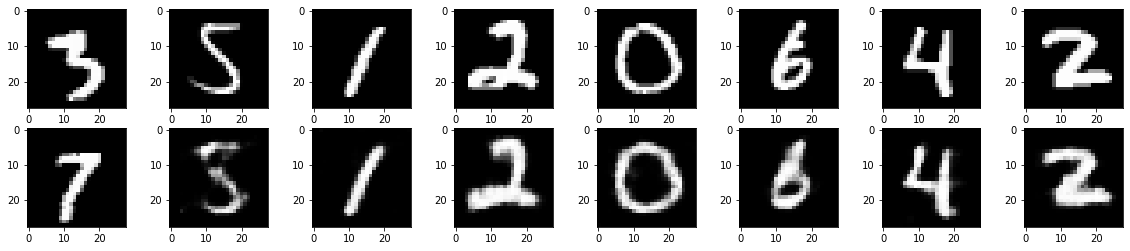

In [11]:
# visualize reconstructed images
n = 8
plt.figure(figsize=(20, 4))
for i in range(1, batch_size):
  # display original
  ax = plt.subplot(2, n, i)
  plt.imshow(X_val[i,0,...].cpu().detach())
  plt.gray()
  #ax.get_xaxis().set_visible(False)
  #ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i+n)
  plt.imshow(reconstr_val[i,0,...].cpu().detach())
  plt.gray()
  #ax.get_xaxis().set_visible(False)
  #ax.get_yaxis().set_visible(False)
plt.show()

### Feature transfer

In [19]:
# check dataset
print(dataset1, len(dataset1))
print(type(dataset1[0][0]), dataset1[0][0].shape, dataset1[0][1])

Dataset MNIST
    Number of datapoints: 6742
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           ) 6742
<class 'torch.Tensor'> torch.Size([1, 28, 28]) 1


In [27]:
dataset1.data[:15].shape

torch.Size([15, 28, 28])

In [28]:
# get 15 images for dataset1 and dataset2
idx1 = dataset.targets == 1
idx2 = dataset.targets == 2

# create copies of dataset
dataset1 = MNIST('./data', transform=img_transform, download=True)
dataset2 = MNIST('./data', transform=img_transform, download=True)
print('check type dataet1: ', type(dataset1))

# extract ones
dataset1.targets = dataset.targets[idx1]
dataset1.data = dataset.data[idx1]
dataset2.targets = dataset.targets[idx2]
dataset2.data = dataset.data[idx2]

# check datasets
print('check idx: ', idx1.shape, idx1)
print(len(dataset1), dataset1.targets)
print(len(dataset2), dataset2.targets)

set1, set2 = [], []
for idx in range(len(dataset1.data[:15])):
  set1.append(dataset1[idx][0].numpy())
for idx in range(len(dataset2.data[:15])):
  set2.append(dataset2[idx][0].numpy())

# convert datasets into tensors
tensor1 = torch.tensor(np.stack(set1)).to(device)
tensor2 = torch.tensor(np.stack(set2)).to(device)
print(type(tensor1), tensor1.shape, tensor2.shape)

check type dataet1:  <class 'torchvision.datasets.mnist.MNIST'>
check idx:  torch.Size([60000]) tensor([False, False, False,  ..., False, False, False])
6742 tensor([1, 1, 1,  ..., 1, 1, 1])
5958 tensor([2, 2, 2,  ..., 2, 2, 2])
<class 'torch.Tensor'> torch.Size([15, 1, 28, 28]) torch.Size([15, 1, 28, 28])


In [29]:
# compute latent codes for 2 subsets
with torch.no_grad():
  autoencoder.eval()
  code1 = autoencoder.encoder(tensor1)
  code2 = autoencoder.encoder(tensor2)
  
# compute delta vector by substruction of mean of 2 codes
delta_code = torch.mean(code2 - code1, dim=0)
print(code1.shape, code2.shape, delta_code.shape)

torch.Size([15, 64, 2, 2]) torch.Size([15, 64, 2, 2]) torch.Size([64, 2, 2])


In [41]:
# add properties of dataset2 to reconstructed samples of dataset1

# for dataset1 define Loader1
Loader1 = DataLoader(dataset1, batch_size=batch_size, shuffle=False)

# compute latent code
with torch.no_grad():
  autoencoder.eval()
  batch, _ = next(iter(Loader1))
  X = batch.to(device).float()
  batch_code = autoencoder.encoder(X)
  print(batch_code.shape, type(batch_code))
  
  # add delta_code to the batch_code
  batch_code += delta_code

  # decode images from result batch_code
  outputs = autoencoder.decoder(batch_code)
  print('outptuts shape: ', outputs.shape)

torch.Size([16, 64, 2, 2]) <class 'torch.Tensor'>
outptuts shape:  torch.Size([16, 1, 28, 28])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


ValueError: ignored

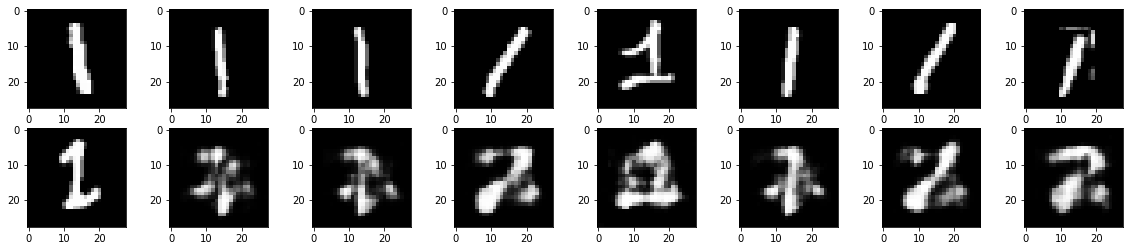

In [42]:
# visualize outputs
n = 8
plt.figure(figsize=(20, 4))
for i in range(1, batch_size):
  # display original
  ax = plt.subplot(2, n, i)
  plt.imshow(X[i,0,...].cpu().detach())
  plt.gray()
  #ax.get_xaxis().set_visible(False)
  #ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i+n)
  plt.imshow(outputs[i,0,...].cpu().detach())
  plt.gray()
  #ax.get_xaxis().set_visible(False)
  #ax.get_yaxis().set_visible(False)
plt.show()